In [38]:
# Setting paths such that this notebook can see the relevant files.
import sys
sys.path.append("./robust-nmf/")

import gzip
import pickle
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from tqdm import tqdm
import torchvision.transforms as transforms
from backends.torch_functions import robust_nmf
from IPython.display import HTML
from IPython.display import Image

In [39]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

In [40]:
train_file = "data/train.pkl"
test_file = "data/test.pkl"
train_data = load_zipped_pickle(train_file)

In [41]:
def perform_rnmf(video, n_components=2, reg_val=10):
    orig_shape = video.shape[1:]
    orig_len = video.shape[0]
    video = video.reshape(video.shape[0], -1)
    print('prermnf:',video.shape)
    basis,coeff,outlier,obj = robust_nmf(data=torch.Tensor(video),rank=n_components, init='NMF',reg_val=reg_val, beta=1, max_iter=300,sum_to_one=False,tol=1e-7, print_every=100)
    print('postrmnf:',outlier.shape)

    return outlier.reshape((orig_len,orig_shape[0],orig_shape[1]))

In [42]:
IMAGE_SIZE = 112

In [43]:
def transform_data(data):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
        ]
    )
    return transform(data)

In [44]:
def pretransform_videos(data, reg_val=10):
    max_height = IMAGE_SIZE
    max_width = IMAGE_SIZE

    num_frames = np.zeros(len(data), dtype=np.int32)
    for i in range(len(data)):
        l = data[i]['video'].shape[-1]
        num_frames[i] = l

    max_length = max(num_frames)

    print(f"Remaining videos: {len(data)} with max_length: {max_length}")

    for i in tqdm(range(len(data))):
        video = data[i]['video']
        
        video = transform_data(video).numpy()
        
        nmf = perform_rnmf(np.copy(video), reg_val)
        
        padded_nmf = np.zeros((max_length, max_height, max_width), dtype=np.float64)
        
        padded_nmf[:nmf.shape[0]] = nmf
        data[i]['padded_nmf'] = padded_nmf
        data[i][f"nmf_{reg_val}"] = nmf

    return max_length

In [45]:
reg_vals = [5, 10, 15]

In [46]:
for i in reg_vals:
    pretransform_videos(train_data[0:1], reg_val=i)
np.savez("data/processed.npz", data=train_data)  


Remaining videos: 1 with max_length: 334


  0%|          | 0/1 [00:00<?, ?it/s]

prermnf: (334, 12544)
Initializing rNMF with NMF. Switching to NumPy.
violation: 1.0
violation: 0.3667335809926685
violation: 0.2618969591731922
violation: 0.1971684460153263
violation: 0.15955922323797558
violation: 0.13493517972224517
violation: 0.11689123731732329
violation: 0.1024670692141587
violation: 0.09154171167148578
violation: 0.08309537556470457
violation: 0.07631807770761773
violation: 0.07093571418795577
violation: 0.06657038101432781
violation: 0.06298650397240917
violation: 0.06008288021154811
violation: 0.0575959562834504
violation: 0.05540312912760496
violation: 0.05328605343321625
violation: 0.051261452741974044
violation: 0.049292849870617425
violation: 0.04721025269483787
violation: 0.044732723526180955
violation: 0.042712119128664724
violation: 0.04044593787336712
violation: 0.03834527401182872
violation: 0.036531963241603585
violation: 0.034784389898025604
violation: 0.03320613607114408
violation: 0.03192494491058873
violation: 0.030783237760020263
violation: 0.0

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
  0%|          | 0/1 [00:01<?, ?it/s]

violation: 0.0002654491822018797
violation: 0.00025802802724541544
Done. Switching back to PyTorch.


AssertionError: Torch not compiled with CUDA enabled

MovieWriter ffmpeg unavailable; using Pillow instead.


reg_val: 5


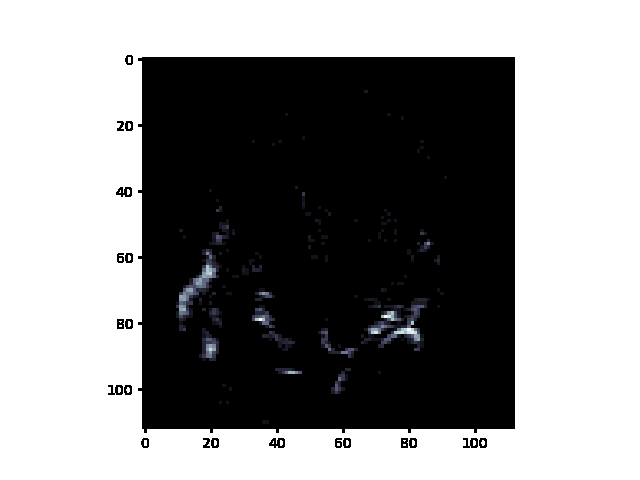

MovieWriter ffmpeg unavailable; using Pillow instead.


reg_val: 10


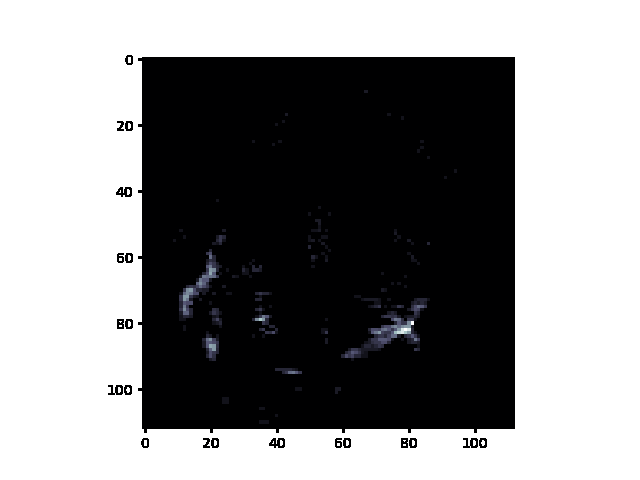

MovieWriter ffmpeg unavailable; using Pillow instead.


reg_val: 15


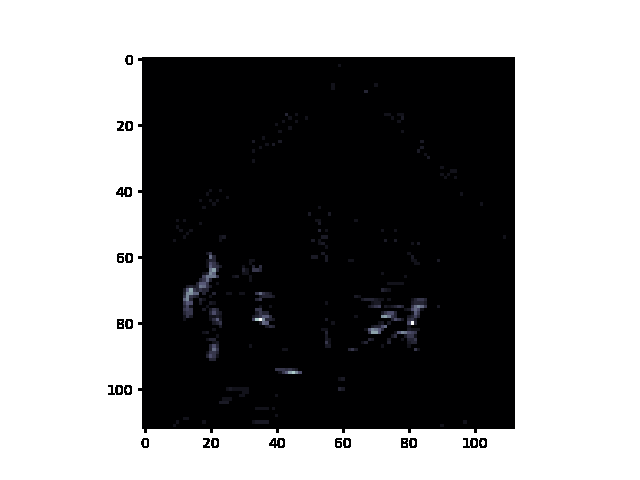

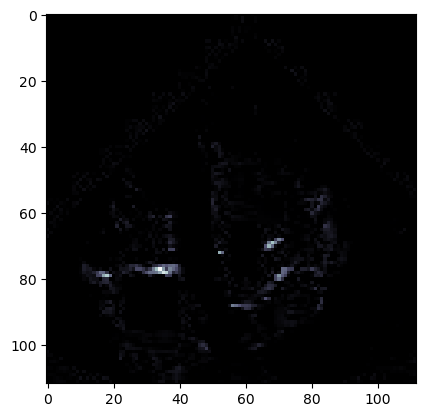

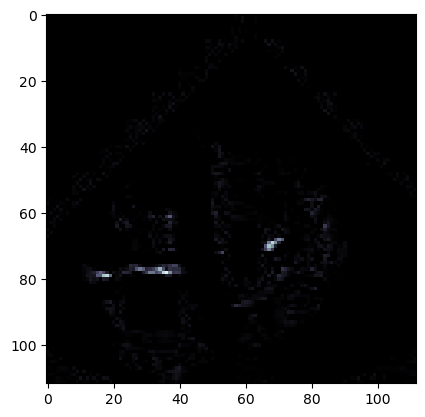

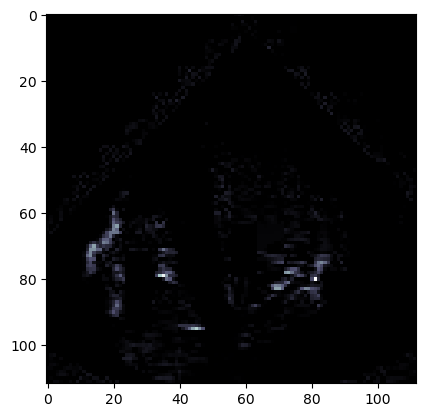

In [ ]:
for i in reg_vals:
    print(f"reg_val: {i}")
    video = train_data[0][f"nmf_{i}"]
    video = np.moveaxis(video,0,-1)
    # print(video.shape)
    fig = plt.figure(frameon=False)
    # plt.margins(0,0)
    im = plt.imshow(video[:,:,0], animated=True, cmap=plt.cm.bone)
    def fig_update(i):
        i = i % video.shape[0]
        im.set_array(video[:,:,i])
        return [im]
    anim = animation.FuncAnimation(fig, fig_update, frames=video.shape[-1], )
    anim.save("img/tmp.gif", fps=20)

    with open('img/tmp.gif','rb') as file:
        display(Image(file.read()))